## Finansial Time Series Forecasting using Artificial Neural Networks

### Importing the dataset
The daily Open/Higth/Low/Close data for the stock of American Airlines Group Inc (NASDAQ: AAL) ( and  Reliance Industries Limited - (NSE: RELIANCE) is used in this forecast research.
The dropna() function is used to drop the missing values. Only the Open/Higth/Low/Close data are used while dataset also contains the Date, Adjusted Close and Volume data.

In [14]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image

In [25]:
# import dataset 
dataset = pd.read_csv('stock_market_data-AAL.csv', index_col = 0)
df_stock = dataset.copy()
print(df_stock[3383:])
df_stock = df_stock.dropna().sort_values(by=['Date'])
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]
print(df_stock[:10])
print('Dataset shape = ',df_stock.shape)

         Date    Low   High  Close   Open
9  2005-10-10  22.10  22.29  22.21  22.28
8  2005-10-07  21.80  22.60  22.15  22.25
7  2005-10-06  22.40  23.00  22.58  22.60
6  2005-10-05  21.75  22.31  22.20  22.10
5  2005-10-04  21.44  22.50  22.16  21.44
4  2005-10-03  20.90  21.75  21.50  20.90
3  2005-09-30  20.18  21.05  21.01  20.26
2  2005-09-29  20.10  20.58  20.21  20.40
1  2005-09-28  19.20  20.53  20.50  19.30
0  2005-09-27  19.10  21.40  19.30  21.05
    Open   High    Low  Close
0  21.05  21.40  19.10  19.30
1  19.30  20.53  19.20  20.50
2  20.40  20.58  20.10  20.21
3  20.26  21.05  20.18  21.01
4  20.90  21.75  20.90  21.50
5  21.44  22.50  21.44  22.16
6  22.10  22.31  21.75  22.20
7  22.60  23.00  22.40  22.58
8  22.25  22.60  21.80  22.15
9  22.28  22.29  22.10  22.21
Dataset shape =  (3393, 4)


### Standardizing the dataset
The process makes the *mean of all the input features equal to zero* and *variance to 1* therefore there is *no bias* while training the model because of the different scales of all input features.

Without scaling the neural network might get confused and give a higher weight to those features which have a higher average value than others. Another reason is that most common activation functions of the network’s neurons such as `tanh` or `sigmoid` are defined on the [-1, 1] or [0, 1] interval respectively. 

The _rectified linear unit_, also known as `ReLU`, activations are commonly used activations which are unbounded on the axis of possible activation values. However, we will scale both the inputs and targets. The scaling is performed using sklearn’s `MinMaxScaler`.

In [31]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
print(df_stock_norm)

          Open      High       Low     Close
0     0.315980  0.316297  0.291495  0.286648
1     0.287239  0.302090  0.293146  0.306259
2     0.305305  0.302907  0.308010  0.301520
3     0.303005  0.310581  0.309331  0.314594
4     0.313516  0.322012  0.321222  0.322602
5     0.322385  0.334259  0.330140  0.333388
6     0.333224  0.331156  0.335260  0.334042
7     0.341435  0.342423  0.345995  0.340252
8     0.335687  0.335892  0.336086  0.333224
9     0.336180  0.330830  0.341040  0.334205
10    0.335852  0.330993  0.336086  0.330446
11    0.329939  0.326911  0.333443  0.326851
12    0.326655  0.322828  0.329480  0.326034
13    0.329118  0.332626  0.336912  0.335185
14    0.334045  0.329686  0.336912  0.332080
15    0.332567  0.330993  0.328654  0.322438
16    0.321235  0.319562  0.320396  0.320641
17    0.320907  0.317603  0.320396  0.314757
18    0.315487  0.332952  0.323039  0.330119
19    0.331746  0.331973  0.338563  0.335839
20    0.335687  0.334912  0.334434  0.330773
21    0.33

### Splitting the dataset into Training and Testing: building X & Y
The whole dataset is split into train, valid and test data. 
The result is: `x_train`, `y_train`, `x_valid`, `y_valid`, `x_test` and `y_test`. This is a crucial part.

In [32]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.values
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2699, 19, 4)
y_train.shape =  (2699, 4)
x_valid.shape =  (337, 19, 4)
y_valid.shape =  (337, 4)
x_test.shape =  (337, 19, 4)
y_test.shape =  (337, 4)


Our total data set is 3393.

So the first 19 data points are x_train.

The next 2699 data points are y_train out of which last 19 data points are x_valid.

The next 337 data points are y_valid out of which last 19 data are x_test.

Finally, the next and last 337 data points are y_test.


### Building the Model
The code supports four different models – Basic RNN Cell, Basic LSTM Cell, LSTM Cell with peephole connections and GRU cell. This notebook is desined to run one model at a time.

#### Parameters, Placeholders & Variables
We will first fix the Parameters, Placeholders & Variables to building any model. The Artificial Neural Network starts with placeholders. We need two placeholders in order to fit our model: X contains the network’s inputs (features of the stock (OHLC) at time _T = t_) and Y the network’s output: _Price of the stock at T+1_. The shape of the placeholders corresponds to [None, n_inputs] with [None] meaning that the inputs are a 2-dimensional matrix and the outputs are a 1-dimensional vector. The crucial part is to properly define the input and output dimensions so the neural net in order to design it properly. 
The variable batch size is 50. It controls the number of observations per training batch. The training is stopped when epoch reaches 100. The 100 epochs is our parameter.

In [33]:
## Building the Model
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

### Designing the network architecture
The function `get_next_batch` runs the next batch for any model . Then we will write the layers for each model separately.

In [34]:
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

Let's run the model using RNN basic.

In [35]:
#RNN 
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)] 
                                                                  
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


### Cost function
This is the cost function to optimize the model. The cost function is used to generate a measure of deviation between the network’s predictions and the actual observed training targets. For regression problems, the _mean squared error_ (`MSE`) function is commonly used. `MSE` computes the average squared deviation between predictions and targets.

In [36]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

### Optimizer
The optimizer takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training. Those computations invoke the _calculation of gradients_ that indicate the direction in which the _weights and biases have to be changed_ during training in order to minimize the network’s cost function. The development of stable and speedy optimizers is a *major field in neural network and deep learning research*.

In [37]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In this model we use Adam (Adaptive Moment Estimation) Optimizer, which is an extension of the stochastic gradient descent, is one of the default optimizers in deep learning development.

### Fitting the neural network model & prediction
Now we need to fit the model that we have created to our train datasets. After having defined the placeholders, variables, initializers, cost functions and optimizers of the network, the model needs to be trained. Usually, this is done by mini batch training. During mini batch training random data samples of n = batch_size are drawn from the training data and fed into the network.

The training dataset gets divided into n / batch_size batches that are sequentially fed into the network. At this point the placeholders X and Y come into play. They store the input and target data and present them to the network as inputs and targets.

A sampled data batch of X flows through the network until it reaches the output layer. There, TensorFlow compares the model’s predictions against the actual observed targets Y in the current batch. Afterwards, TensorFlow conducts an optimization step and updates the network parameters, corresponding to the selected learning scheme. After having updated the weights and biases, the next batch is sampled and the process repeats itself.

The procedure continues until all batches have been presented to the network. One full sweep over all batches is called an epoch.

The training of the network stops once the maximum number of epochs is reached or another stopping criterion defined by the user applies. We stop the training network when epoch reaches 100 as we have given epoch as 100 in our parameter.

In [38]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})


0.00 epochs: MSE train/valid = 0.281718/0.430836
4.98 epochs: MSE train/valid = 0.000284/0.000306
9.97 epochs: MSE train/valid = 0.000329/0.000477
14.95 epochs: MSE train/valid = 0.000206/0.000264
19.93 epochs: MSE train/valid = 0.000149/0.000174
24.92 epochs: MSE train/valid = 0.000145/0.000181
29.90 epochs: MSE train/valid = 0.000154/0.000209
34.88 epochs: MSE train/valid = 0.000132/0.000157
39.87 epochs: MSE train/valid = 0.000124/0.000156
44.85 epochs: MSE train/valid = 0.000128/0.000156
49.83 epochs: MSE train/valid = 0.000138/0.000183
54.82 epochs: MSE train/valid = 0.000259/0.000441
59.80 epochs: MSE train/valid = 0.000127/0.000155
64.78 epochs: MSE train/valid = 0.000133/0.000223
69.77 epochs: MSE train/valid = 0.000135/0.000208
74.75 epochs: MSE train/valid = 0.000195/0.000357
79.73 epochs: MSE train/valid = 0.000132/0.000161
84.72 epochs: MSE train/valid = 0.000118/0.000172
89.70 epochs: MSE train/valid = 0.000112/0.000146
94.68 epochs: MSE train/valid = 0.000121/0.000162
99.

Now we have predicted the stock prices and saved as y_test_pred. We can compare these predicted stock prices with our target stock prices which is y_test. Just to check no of output, I run the below code and its 337 which is matching with y_test data.

In [40]:
#checking prediction output nos 
y_test_pred.shape

(337, 4)

Let’s compare between our target and prediction. I put both target (y_test) & prediction (y_test_pred) closing price in one data frame named as “comp”. Now I put both prices in one graph, let see how it looks.

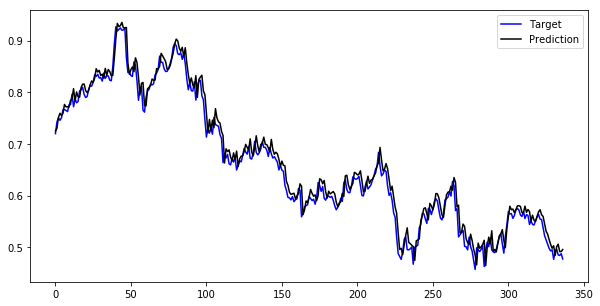

In [41]:
# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

Now we can see, the results are not bad. The prediction values are exactly the same as the target value and moving in the same direction as we expect. You can check the difference between these two and compare the results in various ways & optimize the model before you build your trading strategy.

### Conclusion
The objective of this project is to make you understand how to build different neural network model like RNN, LSTM & GRU in python tensor flow and predicting stock price. You can optimize this model in various ways and build your own trading strategy to get a good strategy return considering Hit Ratio, draw down etc.

Another important factor, we have used daily prices in this model so the data points are really less only 5,640 data points. My advice is to use more than 100,000 data points (use minute or tick data) for training the model when you are building Artificial Neural Network or any other Deep Learning model that will be most effective.

Now you can build your own trading strategy using the power and intelligence of your machines.